In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
ticker = 'AAPL'  # Apple stock
start_date = '2010-01-01'
end_date = '2023-12-31'

data = yf.download(ticker, start=start_date, end=end_date)

print(data.tail())


/tmp/ipython-input-109069549.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2023-12-22  191.974686  193.769488  191.349970  193.541408  37149600
2023-12-26  191.429291  192.262235  191.211137  191.984587  28919300
2023-12-27  191.528442  191.875510  189.485739  190.873995  48087700
2023-12-28  191.954849  193.025784  191.548288  192.510145  34049900
2023-12-29  190.913651  192.767946  190.120364  192.272144  42672100


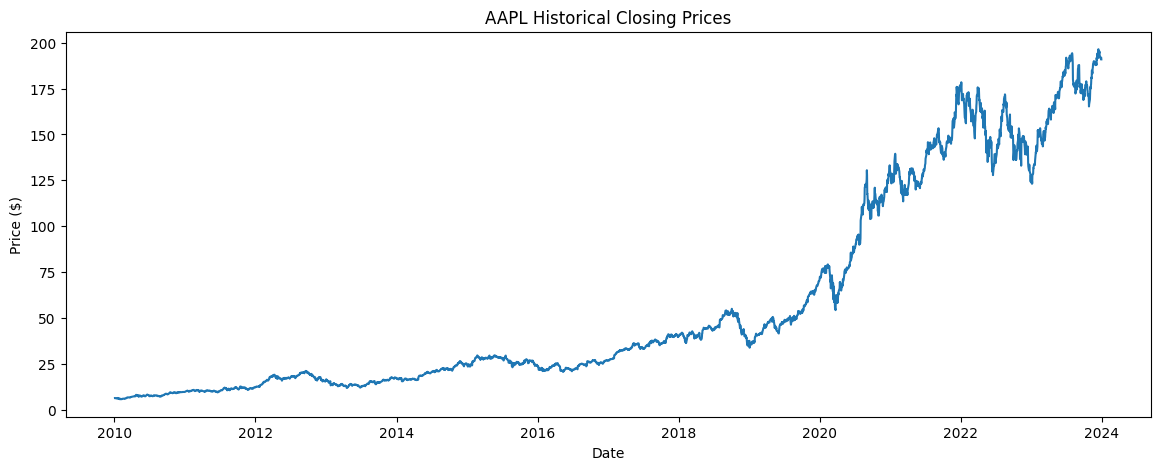

In [3]:
df = data[['Close']].copy()

plt.figure(figsize=(14,5))
plt.title(f'{ticker} Historical Closing Prices')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [5]:
training_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]


In [6]:
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


In [8]:
seq_length = 60  # Using 60 days to predict next day
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")


Training shape: (2757, 60, 1)
Testing shape: (645, 60, 1)


In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - loss: 6.4978e-04 - val_loss: 0.0016
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 5.8134e-04 - val_loss: 0.0019
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 5.8026e-04 - val_loss: 0.0013
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 4.4878e-04 - val_loss: 0.0054
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 8.7789e-04 - val_loss: 0.0096
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 4.6158e-04 - val_loss: 0.0011
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 5.2102e-04 - val_loss: 0.0040
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 3.8106e-04 - val_loss: 0.0062
Epoch 10/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 5.5450e-04 - val_loss: 0.0048
Epoch 11/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 4.8391e-04 - val_loss: 0.0

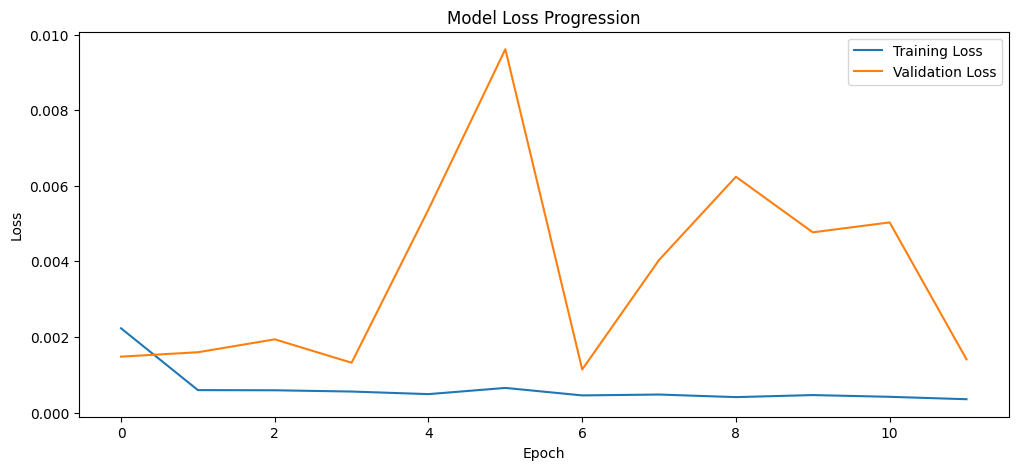

In [13]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [16]:
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

In [17]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

train_rmse = rmse(y_train_actual[0], train_predict[:,0])
test_rmse = rmse(y_test_actual[0], test_predict[:,0])

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 2.63
Test RMSE: 6.44


In [18]:
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[seq_length:len(train_predict)+seq_length, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(seq_length*2):len(scaled_data), :] = test_predict

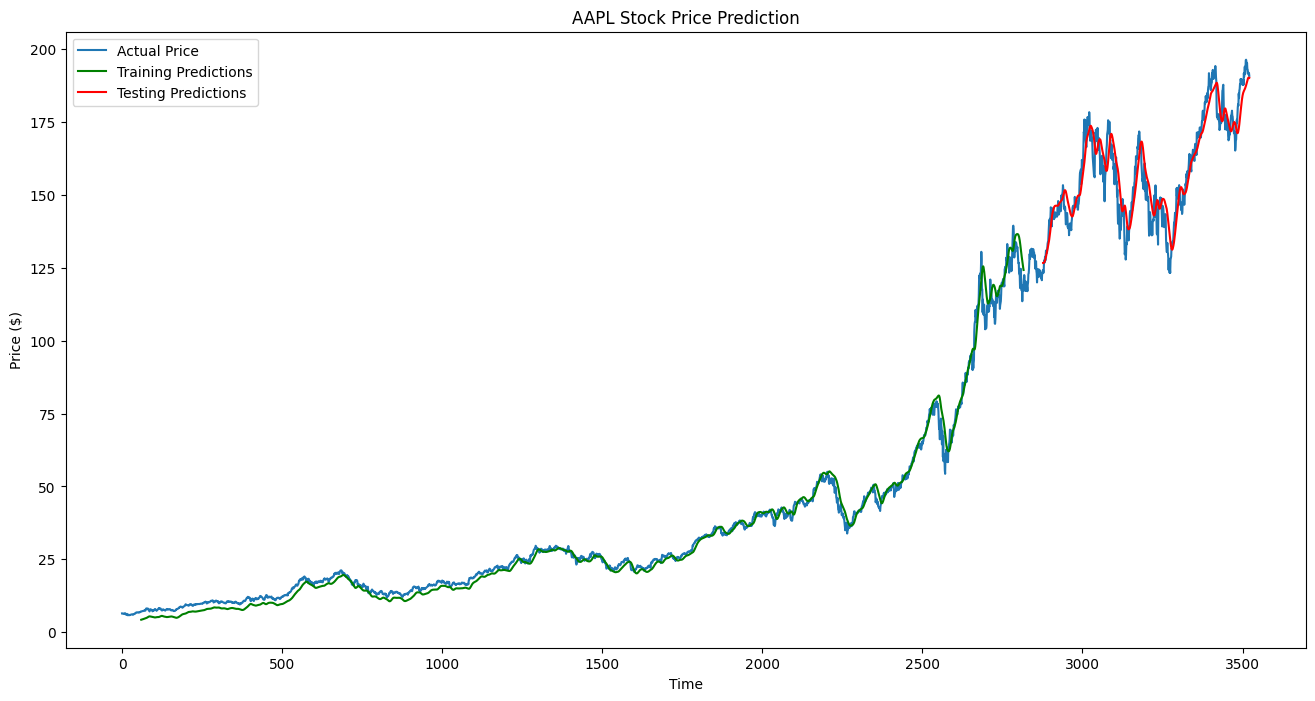

In [19]:
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Stock Price Prediction')
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(train_plot, 'g', label='Training Predictions')
plt.plot(test_plot, 'r', label='Testing Predictions')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [20]:
def predict_future(model, last_sequence, days=30):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        next_pred = model.predict(current_sequence.reshape(1, seq_length, 1))
        future_predictions.append(next_pred[0,0])
        current_sequence = np.append(current_sequence[1:], next_pred)

    return np.array(future_predictions)

In [21]:
last_sequence = scaled_data[-seq_length:]
future_predictions = predict_future(model, last_sequence, 30)
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [22]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

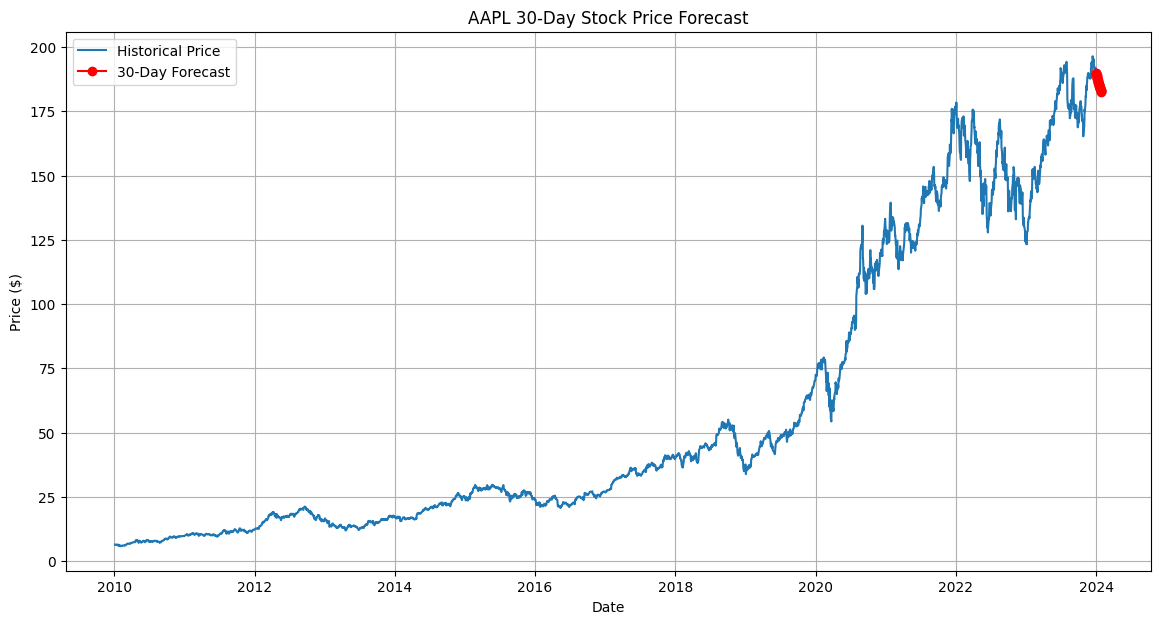

Future Price Predictions:


In [24]:
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Historical Price')
plt.plot(future_dates, future_predictions, 'ro-', label='30-Day Forecast')
plt.title(f'{ticker} 30-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

print("Future Price Predictions:")
